### osu!nn #2: rhythm estimator

Builds up a rhythm model to estimate the rhythm using music and timing data.

Synthesis of "flowData"
* rhythmData x 1
* (Audio) x 3
* (Classifier) x 1

Synthesis Time: ~5 mins

Final edit: 2019/4/22

First of all, Import the wheels.

"root" points to the folder that stores all the .npz map data, where all files in .npz extension are read.

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re

In [2]:
root = "mapdata/";

# updated! now we can set divisor to any number (needs to be consistent with other pages)
divisor = 4;

# this is a global variable!
time_interval = 16;

In [3]:
# lst file, [TICK, TIME, NOTE, IS_CIRCLE, IS_SLIDER, IS_SPINNER, IS_SLIDER_END, IS_SPINNER_END, 
#               0,    1,    2,         3,         4,          5,             6,              7,
#            SLIDING, SPINNING, MOMENTUM, ANGULAR_MOMENTUM, EX1, EX2, EX3], length MAPTICKS
#                  8,        9,       10,               11,  12,  13,  14,
# wav file, [len(snapsize), MAPTICKS, 2, fft_size//4]
def read_npz(fn):
    with np.load(fn) as data:
        wav_data = data["wav"];
        wav_data = np.swapaxes(wav_data, 2, 3);
        train_data = wav_data;
        div_source = data["lst"][:, 0];
        div_source2 = data["lst"][:, 12:15];
        div_data = np.concatenate([divisor_array(div_source), div_source2], axis=1);
        lst_data = data["lst"][:, 2:10];
        # Change the 0/1 data to -1/1 to use tanh instead of softmax in the NN.
        # Somehow tanh works much better than softmax, even if it is a linear combination. Maybe because it is alchemy!
        lst_data = 2 * lst_data - 1;
        train_labels = lst_data;
    return train_data, div_data, train_labels;

def divisor_array(t):
    d_range = list(range(0, divisor));
    return np.array([[int(k % divisor == d) for d in d_range] for k in t]);

def read_npz_list():
    npz_list = [];
    for file in os.listdir(root):
        if file.endswith(".npz"):
            npz_list.append(os.path.join(root, file));
    # reutnr npz_lsit;
    return npz_list;

def prefilter_data(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered):
    # Filter out slider ends from the training set, since we cannot reliably decide if a slider end is on a note.
    # Another way is to set 0.5 for is_note value, but that will break the validation algorithm.
    # Also remove the IS_SLIDER_END, IS_SPINNER_END columns which are left to be zeros.

    # Before: NOTE, IS_CIRCLE, IS_SLIDER, IS_SPINNER, IS_SLIDER_END, IS_SPINNER_END, SLIDING, SPINNING
    #            0,         1,         2,          3,             4,              5,       6,        7
    # After:  NOTE, IS_CIRCLE, IS_SLIDER, IS_SPINNER, SLIDING, SPINNING
    #            0,         1,         2,          3,       4,        5

    non_object_end_indices = [i for i,k in enumerate(train_labels_unfiltered) if k[4] == -1 and k[5] == -1];
    train_data = train_data_unfiltered[non_object_end_indices];
    div_data = div_data_unfiltered[non_object_end_indices];
    train_labels = train_labels_unfiltered[non_object_end_indices][:, [0, 1, 2, 3, 6, 7]];
    
    # should be (X, 7, 32, 2) and (X, 6) in default sampling settings
    # (X, fft_window_type, freq_point, magnitude/phase)
    return train_data, div_data, train_labels;

def preprocess_npzs(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered):
    train_data, div_data, train_labels = prefilter_data(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered);
    # In this version, the train data is already normalized, no need to do it again here
#     mean = train_data.mean(axisprefilter_=0)
#     std = train_data.std(axis=0)
#     train_data = (train_data - np.tile(mean, (train_data.shape[0], 1,1,1))) / np.tile(std, (train_data.shape[0], 1,1,1))
    
    # Make time intervals from training data
    if train_data.shape[0]%time_interval > 0:
        train_data = train_data[:-(train_data.shape[0]%time_interval)];
        div_data = div_data[:-(div_data.shape[0]%time_interval)];
        train_labels = train_labels[:-(train_labels.shape[0]%time_interval)];
    train_data2 = np.reshape(train_data, (-1, time_interval, train_data.shape[1], train_data.shape[2], train_data.shape[3]))
    div_data2 = np.reshape(div_data, (-1, time_interval, div_data.shape[1]))
    train_labels2 = np.reshape(train_labels, (-1, time_interval, train_labels.shape[1]))
    return train_data2, div_data2, train_labels2;

def get_data_shape():
    for file in os.listdir(root):
        if file.endswith(".npz"):
            train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered = read_npz(os.path.join(root, file));
            train_data, div_data, train_labels = prefilter_data(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered);
            # should be (X, 7, 32, 2) and (X, 6) in default sampling settings
            # (X, fft_window_type, freq_point, magnitude/phase)
            # X = 76255
            # print(train_data.shape, train_labels.shape);
            if train_data.shape[0] == 0:
                continue;
            return train_data.shape, div_data.shape, train_labels.shape;
    print("cannot find npz!! using default shape");
    return (-1, 7, 32, 2), (-1, 3 + divisor), (-1, 6);

def read_some_npzs_and_preprocess(npz_list):
    td_list = [];
    dd_list = [];
    tl_list = [];
    for fp in npz_list:
        if fp.endswith(".npz"):
            _td, _dd, _tl = read_npz(fp);
            if _td.shape[1:] != train_shape[1:]:
                print("Warning: something wrong found in {}! shape = {}".format(fp, _td.shape));
                continue;
            td_list.append(_td);
            dd_list.append(_dd);
            tl_list.append(_tl);
    train_data_unfiltered = np.concatenate(td_list);
    div_data_unfiltered = np.concatenate(dd_list);
    train_labels_unfiltered = np.concatenate(tl_list);
    
    train_data2, div_data2, train_labels2 = preprocess_npzs(train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered);
    return train_data2, div_data2, train_labels2;

def train_test_split(train_data2, div_data2, train_labels2, test_split_count=233):
    new_train_data = train_data2[:-test_split_count];
    new_div_data = div_data2[:-test_split_count];
    new_train_labels = train_labels2[:-test_split_count];
    test_data = train_data2[-test_split_count:];
    test_div_data = div_data2[-test_split_count:];
    test_labels = train_labels2[-test_split_count:];
    return (new_train_data, new_div_data, new_train_labels), (test_data, test_div_data, test_labels);

# (train_data_unfiltered, div_data_unfiltered, train_labels_unfiltered) = read_all_npzs();

train_file_list = read_npz_list();

train_shape, div_shape, label_shape = get_data_shape();

Now build the model.

In [4]:
from tensorflow.keras.models import Model;

def build_model():
    model1 = keras.Sequential([
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 2),
                           data_format='channels_last'),
                           input_shape=(time_interval, train_shape[1], train_shape[2], train_shape[3])),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Conv2D(16, (2, 3),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.MaxPool2D((1, 2),
                           data_format='channels_last')),
        keras.layers.TimeDistributed(keras.layers.Activation(activation=tf.nn.relu)),
        keras.layers.TimeDistributed(keras.layers.Dropout(0.3)),
        keras.layers.TimeDistributed(keras.layers.Flatten()),
        keras.layers.LSTM(64, activation=tf.nn.tanh, return_sequences=True)
    ])
    
    input2 = keras.layers.InputLayer(input_shape=(time_interval, div_shape[1]));
    
    conc = keras.layers.concatenate([model1.output, input2.output]);
    dense1 = keras.layers.Dense(71, activation=tf.nn.tanh)(conc);
    dense2 = keras.layers.Dense(71, activation=tf.nn.relu)(dense1);
    dense3 = keras.layers.Dense(label_shape[1], activation=tf.nn.tanh)(dense2);
    

    
    try:
        optimizer = tf.optimizers.RMSprop(0.001) #Adamoptimizer?
    except:
        optimizer = tf.train.RMSPropOptimizer(0.001) #Adamoptimizer?

    
    final_model = Model(inputs=[model1.input, input2.input], outputs=dense3);
    final_model.compile(loss='mse',
                optimizer=optimizer,
                metrics=[keras.metrics.mae])
    return final_model

model = build_model()
model.summary()

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [Limitless]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train MAE')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val MAE')
    plt.plot(history.epoch, np.array(history.history['loss']), 
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val Loss')
    plt.legend()
    plt.show()

# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=20)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_distributed_input (InputLa [(None, 16, 7, 32, 2 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 16, 6, 31, 16 144         time_distributed_input[0][0]     
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 16, 6, 15, 16 0           time_distributed[0][0]           
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 16, 6, 15, 16 0           time_distr

ぐるぐる。

it seems that with GPU training, "batch_size" must be set to a smaller value like 10 (default is 32), otherwise it will crash. probably because there is not enough GPU memory.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

................

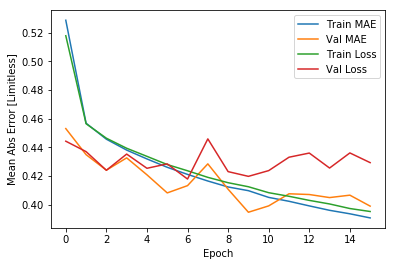


Testing set Mean Abs Error: 0.35816723108291626


In [5]:
# Don't worry, it will successfully overfit after those 16 epochs.
EPOCHS = 16

# since each map npz is about 6mb, this amounts to around 1200mb of RAM.
too_many_maps_threshold = 200
data_split_count = 80

# if there is too much data, reduce epoch count (hmm)
if len(train_file_list) >= too_many_maps_threshold:
    EPOCHS = 6

if len(train_file_list) < too_many_maps_threshold:
    train_data2, div_data2, train_labels2 = read_some_npzs_and_preprocess(train_file_list);

    # Split some test data out
    (new_train_data, new_div_data, new_train_labels), (test_data, test_div_data, test_labels) = train_test_split(train_data2, div_data2, train_labels2);

    # Store training stats
    history = model.fit([new_train_data, new_div_data], new_train_labels, epochs=EPOCHS,
                        validation_split=0.2, verbose=0, #batch_size=10,
                        callbacks=[early_stop, PrintDot()])

    # For development! may cause bug in some environment.
    plot_history(history)
else: # too much data! read it every turn.
    for epoch in range(EPOCHS):
        for map_batch in range(np.ceil(len(train_file_list) / data_split_count).astype(int)): # hmmmmm
            if map_batch == 0:
                train_data2, div_data2, train_labels2 = read_some_npzs_and_preprocess(train_file_list[map_batch * data_split_count : (map_batch+1) * data_split_count]);
                (new_train_data, new_div_data, new_train_labels), (test_data, test_div_data, test_labels) = train_test_split(train_data2, div_data2, train_labels2);
            else:
                new_train_data, new_div_data, new_train_labels = read_some_npzs_and_preprocess(train_file_list[map_batch * data_split_count : (map_batch+1) * data_split_count]);
            
            history = model.fit([new_train_data, new_div_data], new_train_labels, epochs=1,
                                validation_split=0.2, verbose=0, #batch_size=10,
                                callbacks=[])
            # Manually print the dot
            print('.', end='');
        print('');

[loss, mae] = model.evaluate([test_data, test_div_data], test_labels, verbose=0)

print("\nTesting set Mean Abs Error: {}".format(mae))


# print(test_predictions)
# print(test_labels)
# print(test_predictions - list(test_labels))
# print("Mean Abs Error: "+str(np.mean(np.abs(test_predictions - test_labels))))

Print the testing accuracy of the model (using F1-score), and compare with the accuracy of a random result, then in addition print the accuracy of individual columns.

For the Sota dataset, it should get around 0.6 overall score, 0.77 for is_note, and something much smaller for is_circle, is_slider and is_spinner. It may also throw a warning because there is no spinner predicted/actually present.

This is not a very high accuracy - but it is not really a problem; map rhythm does not fully correlate to the music itself. There are overmaps, innovative rhythms... and we can also learn from some of them!

In [6]:
from sklearn.metrics import f1_score

test_predictions = model.predict([test_data, test_div_data]).reshape((-1, time_interval, label_shape[1]))

flat_test_preds = test_predictions.reshape(-1, label_shape[1]);
flat_test_labels = test_labels.reshape(-1, label_shape[1]);

pred_result = (np.sign(flat_test_preds) + 1) / 2
actual_result = (flat_test_labels + 1) / 2

random_result = (1 + np.sign(-1 + 2 * np.random.random(size=pred_result.shape))) / 2;

is_obj_pred = (1 + np.sign(flat_test_preds[:, 0:1])) / 2;
obj_type_pred = np.sign(flat_test_preds[:, 1:4] - np.tile(np.expand_dims(np.max(flat_test_preds[:, 1:4], axis=1), 1), (1, 3))) + 1;
others_pred = (1 + np.sign(flat_test_preds[:, 4:label_shape[1]] + 0.5)) / 2;
# Only predict obj_type when there is an object!
another_pred_result = np.concatenate([is_obj_pred, is_obj_pred * obj_type_pred, others_pred], axis=1);
print(f1_score(actual_result.flatten(), pred_result.flatten()));
print(f1_score(actual_result.flatten(), another_pred_result.flatten()));
print(f1_score(actual_result.flatten(), random_result.flatten()));

# Individual column predictions
column_names = ["is_note", "is_circle", "is_slider", "is_spinner", "is_sliding", "is_spinning"];
for i, k in enumerate(column_names):
    print("{} f1_score: {} from {}".format(k, f1_score(another_pred_result[:, i], actual_result[:, i]), f1_score(random_result[:, i], actual_result[:, i])))

0.6442110655737705
0.6437947494033414
0.2875023947889393
is_note f1_score: 0.872749844816884 from 0.4686003942551394
is_circle f1_score: 0.685126582278481 from 0.4268675455116133
is_slider f1_score: 0.361271676300578 from 0.16072234762979684
is_spinner f1_score: 0.0 from 0.0021321961620469087
is_sliding f1_score: 0.4775184974388162 from 0.35223670306445937
is_spinning f1_score: 0.020408163265306124 from 0.05923694779116466


E:\Stuff\miniconda\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Done! now save the model to the disk.

In [7]:
tf.keras.models.save_model(
    model,
    "saved_rhythm_model",
    overwrite=True,
    include_optimizer=True,
    save_format="h5"
);

# WARNING:tensorflow:TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer
# state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will
# have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
